In [31]:
import sys; print(sys.version)
import os
import glob
import subprocess
import multiprocessing
import io
from collections import OrderedDict
import json

import numpy as np; print('numpy', np.__version__)
import pandas as pd; print('pandas',pd.__version__)
import allel; print('scikit-allel', allel.__version__)
import zarr; print('zarr', zarr.__version__)

import matplotlib as mpl

import statsmodels; print('statsmodels', statsmodels.__version__)
import statsmodels.api as sm

from IPython.display import display, HTML

3.6.7 | packaged by conda-forge | (default, Jul  2 2019, 02:18:42) 
[GCC 7.3.0]
numpy 1.17.0
pandas 0.25.0
scikit-allel 1.2.1
zarr 2.3.2
statsmodels 0.10.1


In [32]:
%matplotlib notebook
mpl.rcParams['figure.facecolor'] = '#BBBBBB'

In [33]:
# name, fai, gtf, chroms
GENOMES = [
    ['AgamP4.11',
     '/data/reference/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP4.fa.fai',
     '../datafiles/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.11.gtf',
     ['2R','2L','3R','3L','X']
    ],
    ['Aaegypti_L5.1',
     '/data/reference/AaegL5.fa.fai',
     '../datafiles/Aedes-aegypti-LVP_AGWG_BASEFEATURES_AaegL5.1.gtf',
     ['1','2','3']
    ],
]


## genome size

In [34]:
for genome_name, faifn, gtffn, chroms in GENOMES:
    t = pd.read_csv(faifn, delimiter='\t', header=None,
                    names=['name','len','offst','linebases','linewidth'])
    total_genome_len = t.loc[t['name'].isin(chroms),'len'].sum()
    print(genome_name, faifn)
    print(chroms)
#     display(t)
    print('total',total_genome_len)

AgamP4.11 /data/reference/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP4.fa.fai
['2R', '2L', '3R', '3L', 'X']
total 230466657
Aaegypti_L5.1 /data/reference/AaegL5.fa.fai
['1', '2', '3']
total 1195030408


In [35]:
# TRANSFN = "../datafiles/transcript_list_{}".format(GENOME)
# tlist = pd.read_csv(TRANSFN, header=None, names=['transcript_id'])
# t = tlist['transcript_id'].str.rsplit('-', n=1, expand=True)
# t.columns = ['gene', 'splice_id']
# tlist = pd.concat((tlist,t), axis=1)

In [36]:
for genome_name, faifn, gtffn, chroms in GENOMES:
    print(genome_name, gtffn)
    d = pd.read_csv(gtffn, sep='\t', comment='#', header=None,
                names=['seqid',
                       'source',
                       'type',
                       'start',
                       'end',
                       'score',
                       'strand',
                       'phase',
                       'attributes'],
                    dtype={'seqid':str})

    # total number of genes
    t = d.loc[d['type']=='gene' ,:].copy(deep=True)
    t['gene_id'] = t['attributes'].apply(
                        lambda x: dict([_.strip().split() for _ in
                        x.split(';') if _])['gene_id'].strip('"'))
    print("total number of genes in gtf:", t['gene_id'].unique().shape[0])

    # list of CDS
    d = d.loc[d['type']=='CDS' ,:]
    d['gene_id'] = d['attributes'].apply(
                        lambda x: dict([_.strip().split() for _ in
                        x.split(';') if _])['gene_id'].strip('"'))
    d['transcript_id'] = d['attributes'].apply(
                        lambda x: dict([_.strip().split() for _ in
                        x.split(';') if _])['transcript_id'].strip('"'))
    # filter to only CRHOMS
    d = d.loc[d['seqid'].isin(chroms) ,:]
    # cdslist = d

    print('Total coding size (sum of CDS lens)',(d['end']-d['start']+1).sum())

    # assert len(set(cdslist['transcript_id'])-set(tlist['transcript_id'])) == 0 # transcripts should be superset of CDS
    # tcdslist = set(tlist['transcript_id']) & set(cdslist['transcript_id'])
    # tcdsdf = tlist[tlist['transcript_id'].isin(tcdslist)]
    # print('# trascripts with CDS:', len(tcdslist))

    # num_coding_genes = tcdsdf['gene'].unique().shape[0]
    # print('# genes with a transcript with a CDS:', num_coding_genes)


AgamP4.11 ../datafiles/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.11.gtf
total number of genes in gtf: 13822
Total coding size (sum of CDS lens) 25728530
Aaegypti_L5.1 ../datafiles/Aedes-aegypti-LVP_AGWG_BASEFEATURES_AaegL5.1.gtf
total number of genes in gtf: 19712
Total coding size (sum of CDS lens) 59121227


## Results summaries from json files

In [37]:
SETNAMES = [
    'VGL-gam',
    'Ag1000g-gam',
    'VGL-col',
    'Ag1000g-col',
    'VGL-Aaeg',
]

In [38]:
dat_any = OrderedDict()
dat_onecall = OrderedDict()
for setname in SETNAMES:
    try:
        with open(setname+'_results.json','r') as fh:
            dat_any[setname] = OrderedDict(json.load(fh))
    except FileNotFoundError as e:
        print(e)
        pass
    with open(setname+'_ignore-one-call_results.json','r') as fh:
        dat_onecall[setname] = OrderedDict(json.load(fh))
#         display(dat[setname])

In [39]:
s = ''
for label,dat in [['any variation',dat_any], 
                  ['ignore single call variants',dat_onecall],
                 ]:
    s += '<h3>'+label+'</h3>\n'
    s += '<table border="1">\n'

    s += '<tr>\n'
    s += '<th></th>\n'
    for k,d in dat.items():
        s += '<th>{:s}</th>\n'.format(k)
    s += '</tr>\n'

    s += '<tr>\n'
    s += '<th>'+'N samples'+'</th>\n'
    for k,d in dat.items():
        s += '<td>{:d}</td>\n'.format(dat[k]['number of samples'])
    s += '</tr>\n'

    s += '<tr>\n'
    s += '<th>'+'good unique targets'+'</th>\n'
    for k,d in dat.items():
        s += '<td>{:d}<br>{:.2f}% T<br>{:.2f}% P</td>\n'.format(
            dat[k]['good unique targets'],
            dat[k]['good unique targets % of total unique'],
            dat[k]['good unique targets % of potential'])
    s += '</tr>\n'

    s += '<tr>\n'
    s += '<th>'+'coding transcripts with good targets'+'</th>\n'
    for k,d in dat.items():
        s += '<td>{:d}<br>{:.2f}%</td>\n'.format(
            dat[k]['coding transcripts w/ good targets'],
            dat[k]['coding transcripts w/ good targets %'])
    s += '</tr>\n'

    s += '<tr>\n'
    s += '<th>'+'coding genes with good targets'+'</th>\n'
    for k,d in dat.items():
        s += '<td>{:d}<br>{:.2f}%</td>\n'.format(
            dat[k]['coding genes w/ good targets'],
            dat[k]['coding genes w/ good targets %'])
    s += '</tr>\n'

    s += '</table>'

display(HTML(s))
# print(s)

,VGL-gam,Ag1000g-gam,VGL-col,Ag1000g-col,VGL-Aaeg
N samples,111,654,100,283,132
good unique targets,2140325.46% T17.89% P,346510.88% T2.90% P,1730384.42% T14.46% P,927572.37% T7.75% P,2724607.49% T32.89% P
coding transcripts with good targets,1304890.06%,532836.78%,1267387.47%,1048772.38%,2501592.43%
coding genes with good targets,1116388.86%,426533.95%,1081086.05%,878269.91%,1190187.50%
,VGL-gam,Ag1000g-gam,VGL-col,Ag1000g-col,VGL-Aaeg
N samples,111,654,100,283,132
good unique targets,2868907.32% T23.98% P,744411.90% T6.22% P,2566266.55% T21.45% P,1836684.69% T15.35% P,3215388.84% T38.81% P
coding transcripts with good targets,1340692.53%,890361.45%,1328891.72%,1249786.26%,2519793.10%
coding genes with good targets,1150891.61%,735858.57%,1139090.67%,1065484.81%,1204088.52%


## filtering by probability of target being reference sequence

In [40]:
def good_counts(tout, num_total_unique_targets, num_coding_genes, min_refAF=None, min_p_ref=None):
    """return counts of good targets and genes derived from tout
    min_refAF filter targets based on the minimum reference allele frequency for for all variants in target
    thereby disregarding low frequency variants
    ...or...
    min_p_ref filter targets based on probability of reference sequence for whole target
    p_ref = the product of the reference freq for all variants in a target 
         ~= probability of reference sequence for whole target
    min_p_ref of 1 means any variants in a target will invalidate it
    """
    
    results_dict = OrderedDict()
    results_dict['total unique targets'] = num_total_unique_targets
    results_dict['coding genes'] = num_coding_genes

    t = tout[['gene','transcript_id','chrom','pos','nv','refAF','p_ref','Genomic location']]
    if min_p_ref is not None:
        good_targets = t[t['p_ref'] >= min_p_ref]
    if min_refAF is not None:
        good_targets = t[t['refAF'].apply(lambda x: min(x,default=1)) >= min_refAF]

    # by target (not put in results_dict)
    print('num potential targets (including non-unique):', t.shape[0])
    print('num good targets (including non-unique):', good_targets.shape[0])
    print("% good targets of potential (including non-unique): {:d}/{:d} = {:0.3f}%".format(
        good_targets.shape[0], t.shape[0], 100*good_targets.shape[0]/t.shape[0]))

    # by unique target
    num_potential_unique_targets = t['Genomic location'].unique().shape[0]
    results_dict['potential unique targets'] = num_potential_unique_targets

    num_good_unique_targets = good_targets['Genomic location'].unique().shape[0]
    results_dict['good unique targets'] = num_good_unique_targets
    results_dict['good unique targets % of total unique'] = (100*
        results_dict['good unique targets']/results_dict['total unique targets'])
    results_dict['good unique targets % of potential'] = (100*
        results_dict['good unique targets']/results_dict['potential unique targets'])

    # by gene
    num_coding_genes = results_dict['coding genes']
    num_potential_genes = t['gene'].unique().shape[0]
    num_good_genes = good_targets['gene'].unique().shape[0]
    results_dict['coding genes w/ potential targets'] = num_potential_genes
    results_dict['coding genes w/ potential targets %'] = (100*
        num_potential_genes/num_coding_genes)
    results_dict['coding genes w/ good targets'] = num_good_genes
    results_dict['coding genes w/ good targets %'] = (100*
        num_good_genes/num_coding_genes)

    return results_dict

In [41]:
SETNAMES = [
    'VGL-gam',
    'Ag1000g-gam',
    'VGL-col',
    'Ag1000g-col',
    'VGL-Aaeg',
]


In [42]:
minRefAF_thresholds = [1, 0.995, 0.990, 0.985, 0.980, 0.5, 0]

saved_results_any = OrderedDict()
res_by_minRefAF = OrderedDict()

for setname in SETNAMES:#[1:2]:
    print(setname)

    # get the main target to variation results... takes a while to load
    tout = pd.read_msgpack(setname+'_tout.msgpack')
    
    # also need a few values from the 'any variation' results
    with open(setname+'_results.json','r') as fh:
        saved_results_any[setname] = OrderedDict(json.load(fh))
    
    for minRefAF_threshold in minRefAF_thresholds:
        if setname not in res_by_minRefAF:
            res_by_minRefAF[setname] = OrderedDict()
        res_by_minRefAF[setname][minRefAF_threshold] = good_counts(tout, 
                                       saved_results_any[setname]['unique location target sites'],
                                       saved_results_any[setname]['coding genes'],
                                       min_refAF=minRefAF_threshold)

VGL-gam
num potential targets (including non-unique): 1198238
num good targets (including non-unique): 214269
% good targets of potential (including non-unique): 214269/1198238 = 17.882%
num potential targets (including non-unique): 1198238
num good targets (including non-unique): 287139
% good targets of potential (including non-unique): 287139/1198238 = 23.963%
num potential targets (including non-unique): 1198238
num good targets (including non-unique): 363276
% good targets of potential (including non-unique): 363276/1198238 = 30.318%
num potential targets (including non-unique): 1198238
num good targets (including non-unique): 423135
% good targets of potential (including non-unique): 423135/1198238 = 35.313%
num potential targets (including non-unique): 1198238
num good targets (including non-unique): 467670
% good targets of potential (including non-unique): 467670/1198238 = 39.030%
num potential targets (including non-unique): 1198238
num good targets (including non-unique): 98

In [43]:
for k,v in res_by_minRefAF.items():
    display(k)
    for k2,v2 in v.items():
        display(k2)
        display(v2)

'VGL-gam'

1

OrderedDict([('total unique targets', 3918579),
             ('coding genes', 12562),
             ('potential unique targets', 1196509),
             ('good unique targets', 214032),
             ('good unique targets % of total unique', 5.461979967738305),
             ('good unique targets % of potential', 17.88803928762759),
             ('coding genes w/ potential targets', 12213),
             ('coding genes w/ potential targets %', 97.22177997134214),
             ('coding genes w/ good targets', 11163),
             ('coding genes w/ good targets %', 88.8632383378443)])

0.995

OrderedDict([('total unique targets', 3918579),
             ('coding genes', 12562),
             ('potential unique targets', 1196509),
             ('good unique targets', 286806),
             ('good unique targets % of total unique', 7.319132777468567),
             ('good unique targets % of potential', 23.970233404011168),
             ('coding genes w/ potential targets', 12213),
             ('coding genes w/ potential targets %', 97.22177997134214),
             ('coding genes w/ good targets', 11506),
             ('coding genes w/ good targets %', 91.59369527145358)])

0.99

OrderedDict([('total unique targets', 3918579),
             ('coding genes', 12562),
             ('potential unique targets', 1196509),
             ('good unique targets', 362842),
             ('good unique targets % of total unique', 9.259530049030529),
             ('good unique targets % of potential', 30.32505396950629),
             ('coding genes w/ potential targets', 12213),
             ('coding genes w/ potential targets %', 97.22177997134214),
             ('coding genes w/ good targets', 11688),
             ('coding genes w/ good targets %', 93.04250915459322)])

0.985

OrderedDict([('total unique targets', 3918579),
             ('coding genes', 12562),
             ('potential unique targets', 1196509),
             ('good unique targets', 422599),
             ('good unique targets % of total unique', 10.784496114535397),
             ('good unique targets % of potential', 35.31933316005145),
             ('coding genes w/ potential targets', 12213),
             ('coding genes w/ potential targets %', 97.22177997134214),
             ('coding genes w/ good targets', 11769),
             ('coding genes w/ good targets %', 93.68731093774876)])

0.98

OrderedDict([('total unique targets', 3918579),
             ('coding genes', 12562),
             ('potential unique targets', 1196509),
             ('good unique targets', 467077),
             ('good unique targets % of total unique', 11.919550428867199),
             ('good unique targets % of potential', 39.036647446864166),
             ('coding genes w/ potential targets', 12213),
             ('coding genes w/ potential targets %', 97.22177997134214),
             ('coding genes w/ good targets', 11816),
             ('coding genes w/ good targets %', 94.06145518229582)])

0.5

OrderedDict([('total unique targets', 3918579),
             ('coding genes', 12562),
             ('potential unique targets', 1196509),
             ('good unique targets', 988154),
             ('good unique targets % of total unique', 25.217151421471915),
             ('good unique targets % of potential', 82.58642433947425),
             ('coding genes w/ potential targets', 12213),
             ('coding genes w/ potential targets %', 97.22177997134214),
             ('coding genes w/ good targets', 12138),
             ('coding genes w/ good targets %', 96.62474128323515)])

0

OrderedDict([('total unique targets', 3918579),
             ('coding genes', 12562),
             ('potential unique targets', 1196509),
             ('good unique targets', 1196509),
             ('good unique targets % of total unique', 30.534257443833592),
             ('good unique targets % of potential', 100.0),
             ('coding genes w/ potential targets', 12213),
             ('coding genes w/ potential targets %', 97.22177997134214),
             ('coding genes w/ good targets', 12213),
             ('coding genes w/ good targets %', 97.22177997134214)])

'Ag1000g-gam'

1

OrderedDict([('total unique targets', 3918579),
             ('coding genes', 12562),
             ('potential unique targets', 1196509),
             ('good unique targets', 34651),
             ('good unique targets % of total unique', 0.8842746311864581),
             ('good unique targets % of potential', 2.89600830415818),
             ('coding genes w/ potential targets', 12213),
             ('coding genes w/ potential targets %', 97.22177997134214),
             ('coding genes w/ good targets', 4265),
             ('coding genes w/ good targets %', 33.951600063684126)])

0.995

OrderedDict([('total unique targets', 3918579),
             ('coding genes', 12562),
             ('potential unique targets', 1196509),
             ('good unique targets', 220530),
             ('good unique targets % of total unique', 5.62780538557472),
             ('good unique targets % of potential', 18.431119197599013),
             ('coding genes w/ potential targets', 12213),
             ('coding genes w/ potential targets %', 97.22177997134214),
             ('coding genes w/ good targets', 10975),
             ('coding genes w/ good targets %', 87.3666613596561)])

0.99

OrderedDict([('total unique targets', 3918579),
             ('coding genes', 12562),
             ('potential unique targets', 1196509),
             ('good unique targets', 337045),
             ('good unique targets % of total unique', 8.601204671387256),
             ('good unique targets % of potential', 28.169031741508004),
             ('coding genes w/ potential targets', 12213),
             ('coding genes w/ potential targets %', 97.22177997134214),
             ('coding genes w/ good targets', 11503),
             ('coding genes w/ good targets %', 91.56981372392931)])

0.985

OrderedDict([('total unique targets', 3918579),
             ('coding genes', 12562),
             ('potential unique targets', 1196509),
             ('good unique targets', 401542),
             ('good unique targets % of total unique', 10.247132953042417),
             ('good unique targets % of potential', 33.55946340562419),
             ('coding genes w/ potential targets', 12213),
             ('coding genes w/ potential targets %', 97.22177997134214),
             ('coding genes w/ good targets', 11634),
             ('coding genes w/ good targets %', 92.61264129915618)])

0.98

OrderedDict([('total unique targets', 3918579),
             ('coding genes', 12562),
             ('potential unique targets', 1196509),
             ('good unique targets', 457853),
             ('good unique targets % of total unique', 11.684158977016924),
             ('good unique targets % of potential', 38.26573807635379),
             ('coding genes w/ potential targets', 12213),
             ('coding genes w/ potential targets %', 97.22177997134214),
             ('coding genes w/ good targets', 11718),
             ('coding genes w/ good targets %', 93.281324629836)])

0.5

OrderedDict([('total unique targets', 3918579),
             ('coding genes', 12562),
             ('potential unique targets', 1196509),
             ('good unique targets', 1013328),
             ('good unique targets % of total unique', 25.85957817872244),
             ('good unique targets % of potential', 84.69037842590403),
             ('coding genes w/ potential targets', 12213),
             ('coding genes w/ potential targets %', 97.22177997134214),
             ('coding genes w/ good targets', 12125),
             ('coding genes w/ good targets %', 96.5212545772966)])

0

OrderedDict([('total unique targets', 3918579),
             ('coding genes', 12562),
             ('potential unique targets', 1196509),
             ('good unique targets', 1196509),
             ('good unique targets % of total unique', 30.534257443833592),
             ('good unique targets % of potential', 100.0),
             ('coding genes w/ potential targets', 12213),
             ('coding genes w/ potential targets %', 97.22177997134214),
             ('coding genes w/ good targets', 12213),
             ('coding genes w/ good targets %', 97.22177997134214)])

'VGL-col'

1

OrderedDict([('total unique targets', 3918579),
             ('coding genes', 12562),
             ('potential unique targets', 1196509),
             ('good unique targets', 173038),
             ('good unique targets % of total unique', 4.415835434222457),
             ('good unique targets % of potential', 14.461905426536699),
             ('coding genes w/ potential targets', 12213),
             ('coding genes w/ potential targets %', 97.22177997134214),
             ('coding genes w/ good targets', 10810),
             ('coding genes w/ good targets %', 86.05317624582072)])

0.995

OrderedDict([('total unique targets', 3918579),
             ('coding genes', 12562),
             ('potential unique targets', 1196509),
             ('good unique targets', 248530),
             ('good unique targets % of total unique', 6.342350122327507),
             ('good unique targets % of potential', 20.77126039168949),
             ('coding genes w/ potential targets', 12213),
             ('coding genes w/ potential targets %', 97.22177997134214),
             ('coding genes w/ good targets', 11352),
             ('coding genes w/ good targets %', 90.3677758318739)])

0.99

OrderedDict([('total unique targets', 3918579),
             ('coding genes', 12562),
             ('potential unique targets', 1196509),
             ('good unique targets', 329380),
             ('good unique targets % of total unique', 8.40559804970118),
             ('good unique targets % of potential', 27.528418089625735),
             ('coding genes w/ potential targets', 12213),
             ('coding genes w/ potential targets %', 97.22177997134214),
             ('coding genes w/ good targets', 11589),
             ('coding genes w/ good targets %', 92.25441808629199)])

0.985

OrderedDict([('total unique targets', 3918579),
             ('coding genes', 12562),
             ('potential unique targets', 1196509),
             ('good unique targets', 399042),
             ('good unique targets % of total unique', 10.183334315832345),
             ('good unique targets % of potential', 33.350522227580406),
             ('coding genes w/ potential targets', 12213),
             ('coding genes w/ potential targets %', 97.22177997134214),
             ('coding genes w/ good targets', 11705),
             ('coding genes w/ good targets %', 93.17783792389747)])

0.98

OrderedDict([('total unique targets', 3918579),
             ('coding genes', 12562),
             ('potential unique targets', 1196509),
             ('good unique targets', 455381),
             ('good unique targets % of total unique', 11.621074884543606),
             ('good unique targets % of potential', 38.059137039504094),
             ('coding genes w/ potential targets', 12213),
             ('coding genes w/ potential targets %', 97.22177997134214),
             ('coding genes w/ good targets', 11774),
             ('coding genes w/ good targets %', 93.7271135169559)])

0.5

OrderedDict([('total unique targets', 3918579),
             ('coding genes', 12562),
             ('potential unique targets', 1196509),
             ('good unique targets', 1002010),
             ('good unique targets % of total unique', 25.57074898834501),
             ('good unique targets % of potential', 83.74445992466417),
             ('coding genes w/ potential targets', 12213),
             ('coding genes w/ potential targets %', 97.22177997134214),
             ('coding genes w/ good targets', 12143),
             ('coding genes w/ good targets %', 96.66454386244229)])

0

OrderedDict([('total unique targets', 3918579),
             ('coding genes', 12562),
             ('potential unique targets', 1196509),
             ('good unique targets', 1196509),
             ('good unique targets % of total unique', 30.534257443833592),
             ('good unique targets % of potential', 100.0),
             ('coding genes w/ potential targets', 12213),
             ('coding genes w/ potential targets %', 97.22177997134214),
             ('coding genes w/ good targets', 12213),
             ('coding genes w/ good targets %', 97.22177997134214)])

'Ag1000g-col'

1

OrderedDict([('total unique targets', 3918579),
             ('coding genes', 12562),
             ('potential unique targets', 1196509),
             ('good unique targets', 92757),
             ('good unique targets % of total unique', 2.3671080766777957),
             ('good unique targets % of potential', 7.752302740723221),
             ('coding genes w/ potential targets', 12213),
             ('coding genes w/ potential targets %', 97.22177997134214),
             ('coding genes w/ good targets', 8782),
             ('coding genes w/ good targets %', 69.90925011940774)])

0.995

OrderedDict([('total unique targets', 3918579),
             ('coding genes', 12562),
             ('potential unique targets', 1196509),
             ('good unique targets', 244537),
             ('good unique targets % of total unique', 6.240450938975583),
             ('good unique targets % of potential', 20.437539542117946),
             ('coding genes w/ potential targets', 12213),
             ('coding genes w/ potential targets %', 97.22177997134214),
             ('coding genes w/ good targets', 11131),
             ('coding genes w/ good targets %', 88.60850183091864)])

0.99

OrderedDict([('total unique targets', 3918579),
             ('coding genes', 12562),
             ('potential unique targets', 1196509),
             ('good unique targets', 358208),
             ('good unique targets % of total unique', 9.141272895097943),
             ('good unique targets % of potential', 29.937760601884314),
             ('coding genes w/ potential targets', 12213),
             ('coding genes w/ potential targets %', 97.22177997134214),
             ('coding genes w/ good targets', 11532),
             ('coding genes w/ good targets %', 91.80066868333068)])

0.985

OrderedDict([('total unique targets', 3918579),
             ('coding genes', 12562),
             ('potential unique targets', 1196509),
             ('good unique targets', 430205),
             ('good unique targets % of total unique', 10.978597088383314),
             ('good unique targets % of potential', 35.95501580013188),
             ('coding genes w/ potential targets', 12213),
             ('coding genes w/ potential targets %', 97.22177997134214),
             ('coding genes w/ good targets', 11664),
             ('coding genes w/ good targets %', 92.85145677439898)])

0.98

OrderedDict([('total unique targets', 3918579),
             ('coding genes', 12562),
             ('potential unique targets', 1196509),
             ('good unique targets', 483944),
             ('good unique targets % of total unique', 12.3499870743961),
             ('good unique targets % of potential', 40.44633178689003),
             ('coding genes w/ potential targets', 12213),
             ('coding genes w/ potential targets %', 97.22177997134214),
             ('coding genes w/ good targets', 11727),
             ('coding genes w/ good targets %', 93.35296927240886)])

0.5

OrderedDict([('total unique targets', 3918579),
             ('coding genes', 12562),
             ('potential unique targets', 1196509),
             ('good unique targets', 1028144),
             ('good unique targets % of total unique', 26.2376744222842),
             ('good unique targets % of potential', 85.92864742346276),
             ('coding genes w/ potential targets', 12213),
             ('coding genes w/ potential targets %', 97.22177997134214),
             ('coding genes w/ good targets', 12138),
             ('coding genes w/ good targets %', 96.62474128323515)])

0

OrderedDict([('total unique targets', 3918579),
             ('coding genes', 12562),
             ('potential unique targets', 1196509),
             ('good unique targets', 1196509),
             ('good unique targets % of total unique', 30.534257443833592),
             ('good unique targets % of potential', 100.0),
             ('coding genes w/ potential targets', 12213),
             ('coding genes w/ potential targets %', 97.22177997134214),
             ('coding genes w/ good targets', 12213),
             ('coding genes w/ good targets %', 97.22177997134214)])

'VGL-Aaeg'

1

OrderedDict([('total unique targets', 3638628),
             ('coding genes', 13601),
             ('potential unique targets', 828454),
             ('good unique targets', 272460),
             ('good unique targets % of total unique', 7.48798723035166),
             ('good unique targets % of potential', 32.88776443833937),
             ('coding genes w/ potential targets', 12536),
             ('coding genes w/ potential targets %', 92.1696934048967),
             ('coding genes w/ good targets', 11901),
             ('coding genes w/ good targets %', 87.50091905006985)])

0.995

OrderedDict([('total unique targets', 3638628),
             ('coding genes', 13601),
             ('potential unique targets', 828454),
             ('good unique targets', 321498),
             ('good unique targets % of total unique', 8.835693013960206),
             ('good unique targets % of potential', 38.806982644781726),
             ('coding genes w/ potential targets', 12536),
             ('coding genes w/ potential targets %', 92.1696934048967),
             ('coding genes w/ good targets', 12039),
             ('coding genes w/ good targets %', 88.51555032718183)])

0.99

OrderedDict([('total unique targets', 3638628),
             ('coding genes', 13601),
             ('potential unique targets', 828454),
             ('good unique targets', 350588),
             ('good unique targets % of total unique', 9.635170179529208),
             ('good unique targets % of potential', 42.31834235817559),
             ('coding genes w/ potential targets', 12536),
             ('coding genes w/ potential targets %', 92.1696934048967),
             ('coding genes w/ good targets', 12091),
             ('coding genes w/ good targets %', 88.89787515623851)])

0.985

OrderedDict([('total unique targets', 3638628),
             ('coding genes', 13601),
             ('potential unique targets', 828454),
             ('good unique targets', 368790),
             ('good unique targets % of total unique', 10.13541367790277),
             ('good unique targets % of potential', 44.51544684436311),
             ('coding genes w/ potential targets', 12536),
             ('coding genes w/ potential targets %', 92.1696934048967),
             ('coding genes w/ good targets', 12134),
             ('coding genes w/ good targets %', 89.21402838026616)])

0.98

OrderedDict([('total unique targets', 3638628),
             ('coding genes', 13601),
             ('potential unique targets', 828454),
             ('good unique targets', 393963),
             ('good unique targets % of total unique', 10.827240377416983),
             ('good unique targets % of potential', 47.553998170085485),
             ('coding genes w/ potential targets', 12536),
             ('coding genes w/ potential targets %', 92.1696934048967),
             ('coding genes w/ good targets', 12182),
             ('coding genes w/ good targets %', 89.56694360708771)])

0.5

OrderedDict([('total unique targets', 3638628),
             ('coding genes', 13601),
             ('potential unique targets', 828454),
             ('good unique targets', 711403),
             ('good unique targets % of total unique', 19.551407838339067),
             ('good unique targets % of potential', 85.8711527737207),
             ('coding genes w/ potential targets', 12536),
             ('coding genes w/ potential targets %', 92.1696934048967),
             ('coding genes w/ good targets', 12467),
             ('coding genes w/ good targets %', 91.66237776634071)])

0

OrderedDict([('total unique targets', 3638628),
             ('coding genes', 13601),
             ('potential unique targets', 828454),
             ('good unique targets', 828454),
             ('good unique targets % of total unique', 22.76830717512205),
             ('good unique targets % of potential', 100.0),
             ('coding genes w/ potential targets', 12536),
             ('coding genes w/ potential targets %', 92.1696934048967),
             ('coding genes w/ good targets', 12536),
             ('coding genes w/ good targets %', 92.1696934048967)])

In [44]:
# load the ignore-one-call results
res_onecall = OrderedDict()
for setname in SETNAMES:
    with open(setname+'_ignore-one-call_results.json','r') as fh:
        res_onecall[setname] = OrderedDict(json.load(fh))

In [45]:
res_onecall

OrderedDict([('VGL-gam',
              OrderedDict([('number of samples', 111),
                           ('total genes', 13822),
                           ('coding transcripts', 14488),
                           ('coding genes', 12562),
                           ('initial target sites in coding transcripts',
                            4606021),
                           ('unique location target sites', 3918579),
                           ('unique targets pass GC filter', 3505626),
                           ('unique targets pass GC filter %',
                            89.46166454727594),
                           ('unique targets pass off-target filter', 1273410),
                           ('unique targets pass off-target filter %',
                            32.49672904387024),
                           ('unique targets pass filters', 1196509),
                           ('unique targets pass filters %',
                            30.534257443833592),
                  

<IPython.core.display.Javascript object>


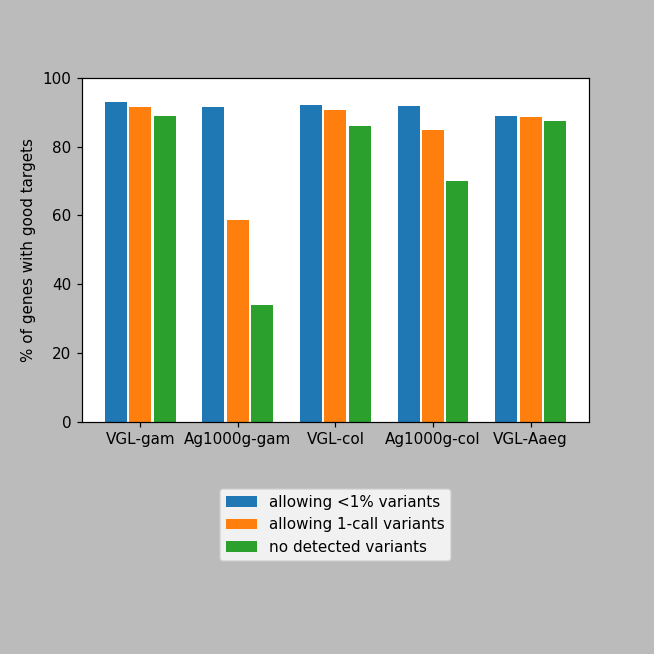

In [46]:
fig,axs = mpl.pyplot.subplots(2,1, squeeze=False, figsize=(6,6),
                             gridspec_kw={'height_ratios': [3, 1]})

barwidth = 0.25

ax = axs[0,0]
y = [res_by_minRefAF[s][0.99]['coding genes w/ good targets %'] for s in SETNAMES]
x = np.arange(0, len(y))
ax.bar(x+0*barwidth, y, width=barwidth*.9, label='allowing <1% variants')

y = [res_onecall[s]['coding genes w/ good targets %'] for s in SETNAMES]
ax.bar(x+1*barwidth, y, width=barwidth*.9, label='allowing 1-call variants')

y = [res_by_minRefAF[s][1]['coding genes w/ good targets %'] for s in SETNAMES]
ax.bar(x+2*barwidth, y, width=barwidth*.9, label='no detected variants')

ax.set_xticks(np.arange(0, len(y))+barwidth)
ax.set_xticklabels(SETNAMES)
ax.set_ylabel('% of genes with good targets')
ax.set_ylim((0,100))

ax_leg = axs[1,0]
lh,ll = ax.get_legend_handles_labels()
ax_leg.legend(lh,ll, loc='center')
ax_leg.set_axis_off()


In [47]:
SETNAMES, LABELS = zip(*[
    ['VGL-gam', 'VGL\n'+r'$\mathit{An. gambiae}$'],
    ['Ag1000g-gam', 'Ag1000g\n'+r'$\mathit{An. gambiae}$'],
    ['VGL-col', 'VGL\n'+r'$\mathit{An. coluzzii}$'],
    ['Ag1000g-col', 'Ag1000g\n'+r'$\mathit{An. coluzzii}$'],
    ['VGL-Aaeg', 'VGL\n'+r'$\mathit{Ae. aegypti}$'],
])

<IPython.core.display.Javascript object>


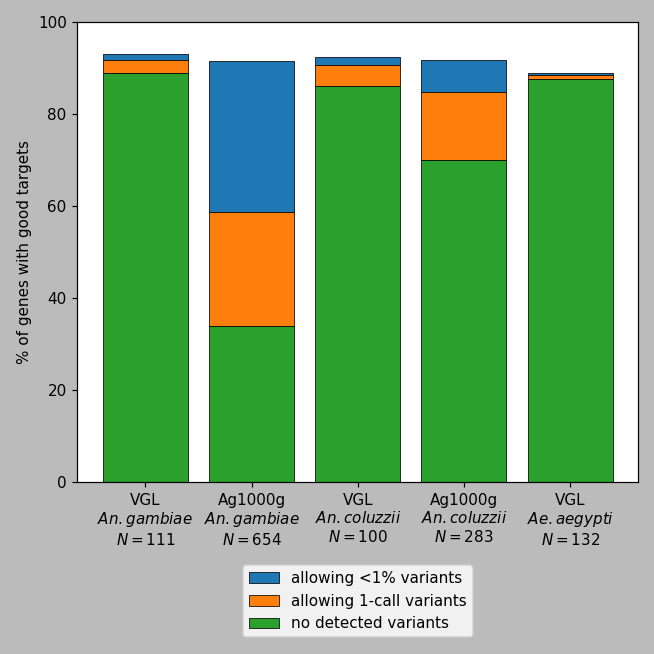

In [48]:
fig,axs = mpl.pyplot.subplots(2,1, squeeze=False, figsize=(6,6),
                             gridspec_kw={'height_ratios': [100, 1]})

barwidth = 1

ax = axs[0,0]
y1 = np.array([res_by_minRefAF[s][0.99]['coding genes w/ good targets %'] for s in SETNAMES])
y2 = np.array([res_onecall[s]['coding genes w/ good targets %'] for s in SETNAMES])
y3 = np.array([res_by_minRefAF[s][1]['coding genes w/ good targets %'] for s in SETNAMES])
x = np.arange(0, len(y1))

ax.bar(x, y1-y2, bottom=y2, width=barwidth*.8, label='allowing <1% variants', edgecolor='k', linewidth=0.5)
ax.bar(x, y2-y3, bottom=y3, width=barwidth*.8, label='allowing 1-call variants', edgecolor='k', linewidth=0.5)
ax.bar(x, y3, bottom=0, width=barwidth*.8, label='no detected variants', edgecolor='k', linewidth=0.5)

ax.set_xticks(np.arange(0, len(y)))#+barwidth)
ax.set_xticklabels([LABELS[i]+ #s.replace('-','\n')+
                    '\n$N='+str(res_onecall[s]['number of samples'])+'$' for i,s in enumerate(SETNAMES)])
# ax.set_xticklabels([s.replace('-','\n')+
#                     '\n$N='+str(res_onecall[s]['number of samples'])+'$' for s in SETNAMES])
ax.set_ylabel('% of genes with good targets')
ax.set_ylim((0,100))

ax_leg = axs[1,0]
lh,ll = ax.get_legend_handles_labels()
ax_leg.legend(lh,ll, loc='center')
ax_leg.set_axis_off()
fig.tight_layout()

fig.savefig('percent_good_genes_overview.svg')
fig.savefig('percent_good_genes_overview.png')

<IPython.core.display.Javascript object>


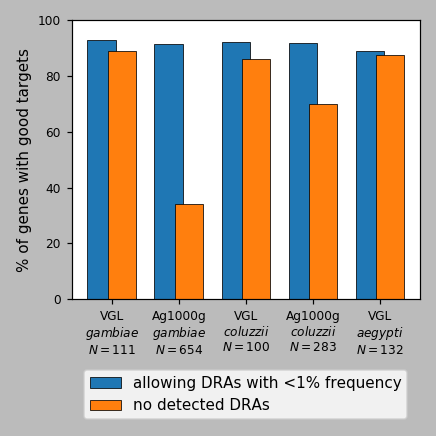

In [50]:
SETNAMES, LABELS = zip(*[
    ['VGL-gam', 'VGL\n'+r'$\mathit{An. gambiae}$'],
    ['Ag1000g-gam', 'Ag1000g\n'+r'$\mathit{An. gambiae}$'],
    ['VGL-col', 'VGL\n'+r'$\mathit{An. coluzzii}$'],
    ['Ag1000g-col', 'Ag1000g\n'+r'$\mathit{An. coluzzii}$'],
    ['VGL-Aaeg', 'VGL\n'+r'$\mathit{Ae. aegypti}$'],
])
SETNAMES, LABELS = zip(*[
    ['VGL-gam', 'VGL\n'+r'$\mathit{gambiae}$'],
    ['Ag1000g-gam', 'Ag1000g\n'+r'$\mathit{gambiae}$'],
    ['VGL-col', 'VGL\n'+r'$\mathit{coluzzii}$'],
    ['Ag1000g-col', 'Ag1000g\n'+r'$\mathit{coluzzii}$'],
    ['VGL-Aaeg', 'VGL\n'+r'$\mathit{aegypti}$'],
])

barwidth = .425
b2off = .3

fig,axs = mpl.pyplot.subplots(2,1, squeeze=False, figsize=(4,4),
                             gridspec_kw={'height_ratios': [100, 1]})

ax = axs[0,0]
y1 = np.array([res_by_minRefAF[s][0.99]['coding genes w/ good targets %'] for s in SETNAMES])
y2 = np.array([res_by_minRefAF[s][1]['coding genes w/ good targets %'] for s in SETNAMES])
x = np.arange(0, len(y1))

# ax.bar(x, y1-y2, bottom=y2, width=barwidth*.8, label='allowing <1% variants', edgecolor='k', linewidth=0.5)
ax.bar(x, y1, bottom=0, width=barwidth, label='allowing DRAs with <1% frequency', edgecolor='k', linewidth=0.5)
ax.bar(x+b2off, y2, bottom=0, width=barwidth, label='no detected DRAs', edgecolor='k', linewidth=0.5)

ax.set_xticks(np.arange(0, len(y))+b2off/2)
ax.set_xticklabels([LABELS[i]+ #s.replace('-','\n')+
                    '\n$N='+str(res_onecall[s]['number of samples'])+'$' for i,s in enumerate(SETNAMES)])
ax.tick_params(axis='both', labelsize=8)
# ax.set_xticklabels([s.replace('-','\n')+
#                     '\n$N='+str(res_onecall[s]['number of samples'])+'$' for s in SETNAMES])
ax.set_ylabel('% of genes with good targets')
ax.set_ylim((0,100))

ax_leg = axs[1,0]
lh,ll = ax.get_legend_handles_labels()
ax_leg.legend(lh,ll, loc='center')
ax_leg.set_axis_off()
fig.tight_layout()

fig.savefig('percent_good_genes_overview.svg')
fig.savefig('percent_good_genes_overview.png')

<IPython.core.display.Javascript object>


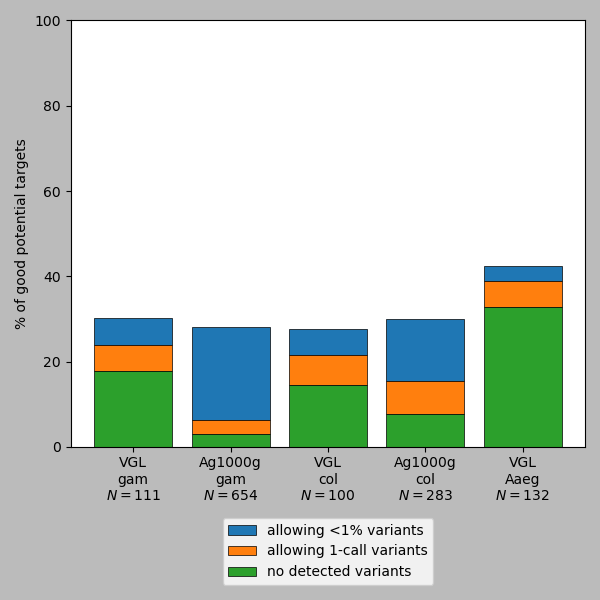

In [20]:
fig,axs = mpl.pyplot.subplots(2,1, squeeze=False, figsize=(6,6),
                             gridspec_kw={'height_ratios': [100, 1]})

barwidth = 1

ax = axs[0,0]
x = np.arange(0, len(y))

y1 = np.array([res_by_minRefAF[s][0.99]['good unique targets % of potential'] for s in SETNAMES])
y2 = np.array([res_onecall[s]['good unique targets % of potential'] for s in SETNAMES])
y3 = np.array([res_by_minRefAF[s][1]['good unique targets % of potential'] for s in SETNAMES])
# y1 = np.array([res_by_minRefAF[s][0.99]['coding genes w/ good targets %'] for s in SETNAMES])
# y2 = np.array([res_onecall[s]['coding genes w/ good targets %'] for s in SETNAMES])
# y3 = np.array([res_by_minRefAF[s][1]['coding genes w/ good targets %'] for s in SETNAMES])

ax.bar(x, y1-y2, bottom=y2, width=barwidth*.8, label='allowing <1% variants', edgecolor='k', linewidth=0.5)
ax.bar(x, y2-y3, bottom=y3, width=barwidth*.8, label='allowing 1-call variants', edgecolor='k', linewidth=0.5)
ax.bar(x, y3, bottom=0, width=barwidth*.8, label='no detected variants', edgecolor='k', linewidth=0.5)

ax.set_xticks(np.arange(0, len(x)))#+barwidth)
ax.set_xticklabels([s.replace('-','\n')+'\n$N='+str(res_onecall[s]['number of samples'])+'$' for s in SETNAMES])
ax.set_ylabel('% of good potential targets')
ax.set_ylim((0,100))

ax_leg = axs[1,0]
lh,ll = ax.get_legend_handles_labels()
ax_leg.legend(lh,ll, loc='center')
ax_leg.set_axis_off()
fig.tight_layout()

# fig.savefig('percent_good_genes_overview.svg')

/home/travc/miniconda3/envs/allel/lib/python3.6/site-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.333
Method:                 Least Squares   F-statistic:                 0.0004121
Date:                Tue, 27 Aug 2019   Prob (F-statistic):              0.985
Time:                        09:39:54   Log-Likelihood:                -8.7803
No. Observations:                   5   AIC:                             21.56
Df Residuals:                       3   BIC:                             20.78
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         91.4930      1.276     71.682      0.000      87.431      95.555
x1          7.829e-05      0.004      0.020      0.985      -0.012       0.012
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.162
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.831
Skew:                          -0.988   Prob(JB):                        0.660
Kurtosis:                       2.703   Cond. No.                         522.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>


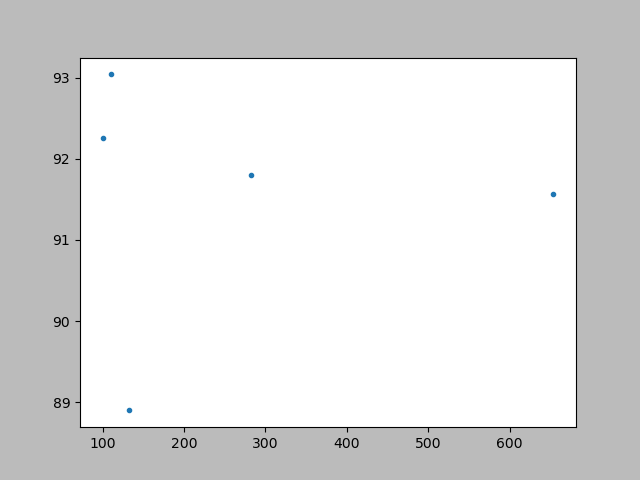

In [21]:
n_samples = [res_onecall[s]['number of samples'] for s in SETNAMES]
gg = np.array([res_by_minRefAF[s][0.99]['coding genes w/ good targets %'] for s in SETNAMES])
# y2 = np.array([res_onecall[s]['coding genes w/ good targets %'] for s in SETNAMES])
# y3 = np.array([res_by_minRefAF[s][1]['coding genes w/ good targets %'] for s in SETNAMES])

model = sm.OLS(gg, sm.add_constant(n_samples)).fit()
display(model.summary())

fig, ax = mpl.pyplot.subplots(1,1)
ax.plot(n_samples, gg, '.')

## targets per gene stats

In [22]:
# setname = 'VGL-gam'
setname = 'Ag1000g-gam'
tout = pd.read_msgpack(setname+'_tout.msgpack')

In [24]:
display(pd.Series(tout['gene'].value_counts()).describe())

count    12213.000000
mean        98.111684
std         94.642816
min          1.000000
25%         40.000000
50%         72.000000
75%        124.000000
max       2042.000000
Name: gene, dtype: float64

In [25]:
setname = 'VGL-Aaeg'
tout = pd.read_msgpack(setname+'_tout.msgpack')

In [26]:
display(pd.Series(tout['gene'].value_counts()).describe())

count    12536.000000
mean        66.258216
std         65.895080
min          1.000000
25%         25.000000
50%         47.000000
75%         86.000000
max       1059.000000
Name: gene, dtype: float64

In [30]:
1-(1-0.03)**47

0.7610695447905139